In [2]:
import pandas as pd
from data_loader import *
from Snowball import *
import matplotlib.pyplot as plt
from WindPy import w
import re

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


In [60]:
import os
i = 0
file_list = os.listdir('zz500_grid')
file_name = file_list[i]

start_date = pd.to_datetime(file_name[6:16]).date()
case_num = file_name[4:5]
r = float(re.search(r'r([\d.]+)_', file_name).group(1))
q = float(re.search(r'q([\d.]+)_', file_name).group(1))
c = float(re.search(r'票息([\d.]+)\.', file_name).group(1))
vol = float(re.search(r'vol([\d.]+)_', file_name).group(1))

file_name


'Case1_2022-11-01_vol0.25_r0.025_q0.02_理论票息0.162.xlsx'

In [61]:
def backtest(snowball, index_data_all):
    """
    Perform backtest on a snowball product
    """
    # Process the backtest using historical index data
    snowball.process_backtest(index_data_all)

    # Compile the backtest results into a pandas Series
    result_series = pd.Series(
        (
            snowball.time_dynamic_param["start_date"],
            snowball.start_price,
            snowball.time_dynamic_param["end_date"],
            snowball.end_price,
            snowball.knockin_date,
            snowball.knockin_price,
            snowball.knockout_date,
            snowball.knockout_price,
            snowball.status,
            snowball.terminal_month,
            snowball.abs_return,
            snowball.annual_return,
            snowball.maturity_sign,
        )
    )
    return result_series


######################################################################################
# ---------------------------- Set Snowball parameters ------------------------------#
# 挂钩标的
underlying = "中证500"

# 价格数据
data_fields = ["close"]

# Snowball
snowball_type = "经典雪球"  # 经典雪球/降敲型雪球/限亏型雪球/限亏止盈型雪球/早利型雪球

# 合约期限
option_expire_month = 24

# # 合约开始日期
# start_date = pd.to_datetime("2016-11-22").date()

# 合约结束日期
end_date = ensure_trading_day(start_date + relativedelta(months=option_expire_month))

# 敲入条件
knockin_barrier = 0.75

# 敲出条件
knockout_barrier = 1
knockout_freq_month = 1

# 票息设置
kickout_coupon = 0.25
regular_coupon = 0.25

# 首个敲出观察日为距离观察起始日后的第x月
observation_start_month = 3

# 追保设置
margin_call = False  # 不允许追保

# ---------------------------- Generate Snowball param dicts ------------------------------#
# 生成固定配置
time_fixed_param = {"option_expire_month": option_expire_month}
time_dynamic_param = {"start_date": start_date, "end_date": end_date}
knockin_param = {"knockin_barrier": knockin_barrier}
knockout_param = {
    "observation_start_month": observation_start_month,
    "knockout_barrier": knockout_barrier,
    "knockout_freq_month": knockout_freq_month,
}
coupon_param = {"kickout_coupon": kickout_coupon, "regular_coupon": regular_coupon}
profit_param = {"margin_call": margin_call}

# ---------------------------- Initialize Snowball object ------------------------------#
# 初始化雪球类
snowball = SnowballOption.create_snowball(
    snowball_type,
    underlying,
    time_fixed_param,
    knockin_param,
    knockout_param,
    coupon_param,
    profit_param,
)
snowball.set_time_param(time_dynamic_param)

# -------------------------------------- Backtest ------------------------------#
# 获取标的价格信息
date_fields = ["close"]
index_data_all = get_underlying_data(
    underlying=underlying,
    data_fields=["close"],
    start_date=start_date,
    end_date=end_date,
    data_source="wind"
)

snowball_info = pd.DataFrame(backtest(snowball, index_data_all))
snowball_info.index = [
    "start_date",
    "start_price",
    "end_date",
    "end_price",
    "knockin_date",
    "knockin_price",
    "knockout_date",
    "knockout_price",
    "status",
    "terminal_month",
    "absolute_return",
    "annualized_return",
    "full_cycle",
]
snowball_info = snowball_info.to_dict()[0]


In [18]:
######################################################################################
# ---------------------------- etf ------------------------------#
# Set risk free rate
r_free = 0.025
r_free_daily = r_free / 365

# Set transaction cost
transaction_cost_etf = 2e-4
transaction_cost_futures = 3e-4

# Read delta grid
# file_name = "case3_new_r0.025_q0.045_vol0.17_理论年化票息11.06%"
delta_grid = pd.read_excel(f"zz500_grid/{file_name}", index_col=0)
delta_grid.columns = delta_grid.columns.map(lambda x: pd.to_datetime(x).date())
delta_grid = delta_grid.map(lambda x: float(x.strip('%')) / 100)
delta_grid.index = delta_grid.index.map(lambda x: float(x.strip('%')) / 100)

if snowball_info["knockout_date"] == pd.to_datetime("1900-01-01").date():
    snowball_end_date = min(snowball.time_dynamic_param['end_date'],
                            last_trading_day(datetime.now().date()))
else:
    snowball_end_date = snowball_info["knockout_date"]

# Get index price data
index_price = get_underlying_data(
    underlying=underlying,
    data_fields=data_fields,
    start_date=start_date,
    end_date=snowball_end_date,
    data_source="wind",
)
index_price_pct = index_price["close"] / index_price.loc[start_date, "close"]

# Match fuures daily trading amount according to delta_grid
match_index = index_price_pct.apply(
    lambda x: delta_grid.index[
        min(range(len(delta_grid.index)), key=lambda i: abs(delta_grid.index[i] - x))
    ]
)

futures_amount_series = pd.Series([
    delta_grid.loc[match_index.iloc[i], match_index.index[i]]
    for i in range(match_index.shape[0])
], index=match_index.index)

futures_amount_series[futures_amount_series>1] = 1 # max hedge
futures_amount_series[futures_amount_series<0] = 0 # min hedge

In [152]:
#---------------------------------------------------------
# get corresponding contract ID during the period

contract_list = []
for year in range(int(str(start_date.year)[2:]),
                  int(str(snowball_end_date.year)[2:]) + 1):
    if year == int(str(start_date.year)[2:]):
        for month in range(max(int(str(start_date.month)) - 1, 1), 13):
            contract = "IC" + str(year) + str(month).zfill(2) + ".CFE"
            contract_list.append(contract)
    elif year == int(str(snowball_end_date.year)[2:]):
        for month in range(1, int(str(end_date.month)) + 2):
            contract = "IC" + str(year) + str(month).zfill(2) + ".CFE"
            contract_list.append(contract)
    else:
        for month in range(1, 13):
            contract = "IC" + str(year) + str(month).zfill(2) + ".CFE"
            contract_list.append(contract)

# Loading all futures data
data_list = []
for contract in contract_list:
    contract_start = pd.to_datetime("20" + contract[2:6] + "01").date() - relativedelta(months=2)
    contract_end = pd.to_datetime("20" + contract[2:6] + "01").date() + relativedelta(months=2)
    data = w.wsd(contract, "close", datetime.strftime(contract_start, "%Y-%m-%d"), datetime.strftime(contract_end, "%Y-%m-%d"), "")
    df = pd.DataFrame(data.Data)
    df.columns = data.Times
    df.index = ['price']
    df = df.dropna(axis=1).T
    df['contract_ID'] = contract
    data_list.append(df)

data_all = pd.concat(data_list)
contract_temp = data_all[~data_all.index.duplicated(keep='first')]
contract_temp = contract_temp[(contract_temp.index>=start_date)&(contract_temp.index<=end_date)].copy()

# futures adjust position date: last date
adjust_datelist = []
for contract in contract_temp['contract_ID'].unique():
    temp = contract_temp[contract_temp['contract_ID'] ==
                         contract].copy().sort_index()
    adjust_date = temp.index[-1]
    adjust_datelist.append(adjust_date)

In [170]:
# calculate reuturn group by each contract
contract_return = contract_temp['price'] /  contract_temp['price'].shift(1) - 1
contract_return = pd.DataFrame(contract_return)
contract_return.columns = ['return']

# reset the return of adjust dates
# replace the price data in contract_temp
contract_all = contract_temp.copy()
contract_adjust_date = []
for i in range(len(adjust_datelist)):
    adjust_date = adjust_datelist[i]

    if adjust_date.month != 12:
        next_contract_ID = "IC" + str(
            adjust_date.year)[2:] + str(adjust_date.month +
                                        1).zfill(2) + ".CFE"
    else:
        next_contract_ID = "IC" + str(adjust_date.year + 1)[2:] + "01" + ".CFE"
    current_contract_ID = "IC" + str(adjust_date.year)[2:] + str(
        adjust_date.month).zfill(2) + ".CFE"

    data_next_contract = data_all[data_all['contract_ID'] == next_contract_ID]
    data_current_contract = data_all[data_all['contract_ID'] ==
                                     current_contract_ID]
    ret = data_next_contract.loc[
        adjust_date, 'price'] / data_current_contract.loc[
            last_trading_day(adjust_date), 'price'] - 1
    contract_return.loc[adjust_date, 'return'] = ret
    contract_all.loc[adjust_date, 'price'] = data_next_contract.loc[adjust_date, 'price']
    contract_all.loc[adjust_date, 'contract_ID'] = next_contract_ID

# e.g. take 2023-11-17 as adjust day, buy IC2312 at the end of 2023-11-16
# the return of 2023-11-17 is calculated using IC2312 at 2023-11-17 / IC2311 at 2023-11-16

In [171]:
# Calculate index daily return
etf_price = get_underlying_data(
    underlying="中证500-ETF",
    data_fields=data_fields,
    start_date=start_date,
    end_date=snowball_end_date,
    data_source="wind",
)
# etf_price = index_price.copy()
etf_return = etf_price / etf_price.shift(1) - 1
etf_return.columns = ['return']

In [172]:
# Calculate daily net value
datelist = get_trading_days_between(
    snowball_info["start_date"], snowball_end_date
)

value_per_point = 200
deposit_ratio = 0.3
initial_value = 1e8

net_value_df = pd.DataFrame(index=datelist, columns=["contract_num", "contract_price", "contract_amount", "deposit_amount", "etf_amount", "risk_free_amount", "net_value"])
net_value_df.loc[datelist[0], "net_value"] = initial_value
futures_amount_real = initial_value * futures_amount_series

last_net_value = initial_value

for i in range(len(datelist)):
    current_date = datelist[i]
    # futures target = etf + futures (only pay deposit, else go to risk-free part)
    futures_target = futures_amount_real.loc[current_date]
    contract_price = value_per_point * contract_all.loc[current_date, "price"]

    contract_num = futures_target // contract_price
    etf_amount = futures_target % contract_price
    contract_amount = contract_num * contract_price
    deposit_amount = contract_amount * deposit_ratio
    risk_free_amount = last_net_value - etf_amount - contract_amount

    net_value_df.loc[current_date, "contract_num"] = contract_num
    net_value_df.loc[current_date, "contract_price"] = contract_price
    net_value_df.loc[current_date, "contract_amount"] = contract_amount
    net_value_df.loc[current_date, "etf_amount"] = etf_amount
    net_value_df.loc[current_date, "deposit_amount"] = deposit_amount
    net_value_df.loc[current_date, "risk_free_amount"] = risk_free_amount

    if i != len(datelist) - 1:
        next_date = datelist[i + 1]
        net_value_contract = contract_amount * (
            1 + contract_return.loc[next_date, "return"])
        net_value_etf = etf_amount * (1 + etf_return.loc[next_date, "return"])
        net_value_rf = risk_free_amount * (1 + r_free_daily)
        net_value = net_value_contract + net_value_etf + net_value_rf

        # Transaction cost -- etf
        if i == 0:
            last_eft_amount = 0
        else:
            last_eft_amount = net_value_df.loc[datelist[i - 1], "etf_amount"]
        etf_cost = abs(etf_amount - last_eft_amount) * transaction_cost_etf

        # Transaction cost -- futures
        if i == 0:
            last_contract_num = 0
        elif current_date in adjust_datelist:
            last_contract_num = -net_value_df.loc[datelist[i - 1],
                                                  "contract_num"]
        else:
            last_contract_num = net_value_df.loc[datelist[i - 1],
                                                 "contract_num"]
        contract_cost = abs(contract_num - last_contract_num
                            ) * contract_price * transaction_cost_futures

        net_value = net_value - etf_cost - contract_cost
        net_value_df.loc[next_date, "net_value"] = net_value


In [173]:
net_value_strategy = pd.DataFrame(net_value_df["net_value"]/initial_value, columns=['net_value'])
net_value_index = pd.DataFrame(index_price['close'] / index_price.loc[start_date, 'close'])
net_value_index.columns = ['net_value']

In [174]:
# case_num = 3
# r = 0.025
# q = 0.045
# c = 0.1106
# vol = 0.17

C:\Users\FEFE\AppData\Local\Temp\ipykernel_25308\3656967267.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


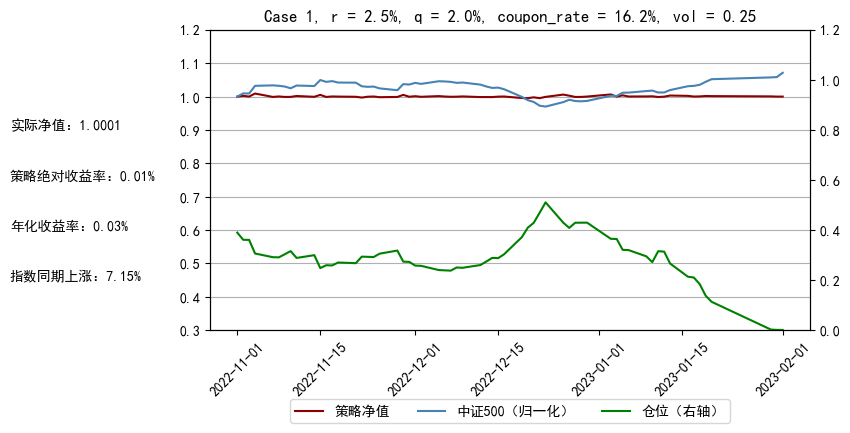

In [175]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(net_value_strategy, color="darkred", label="策略净值")
ax1.plot(net_value_index, color="steelblue", label="中证500（归一化）")
ax1.set_ylim(0.3, 1.2)
# ax1.set_ylim(0.5, 1.4) # case 5
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

plt.grid(axis='y')

ax2 = ax1.twinx()
ax2.plot(futures_amount_series, color="green", label="仓位（右轴）")
# ax2.set_ylim(0, 1) # case 1
ax2.set_ylim(0, 1.2)
# ax2.set_ylim(-0.2, 1.2) # case 5
fig.legend(loc="lower center", bbox_to_anchor=(0.5, 0), ncol=3)

days_between = (net_value_strategy.index[-1] - net_value_strategy.index[0]).days
absolute_return = (net_value_strategy['net_value'].iloc[-1] /
                     net_value_strategy['net_value'].iloc[0] -
                     1)
annualized_return = absolute_return / days_between * 365

plt.text(0, 0.6, f"实际净值：{round(net_value_strategy['net_value'].iloc[-1], 4)}", fontsize=10, transform=plt.gcf().transFigure)
plt.text(0, 0.5, f"策略绝对收益率：{round(absolute_return*100, 2)}%", fontsize=10, transform=plt.gcf().transFigure)
plt.text(0, 0.4, f"年化收益率：{round(annualized_return*100, 2)}%", fontsize=10, transform=plt.gcf().transFigure)
plt.text(
    0,
    0.3,
    f"指数同期上涨：{round((net_value_index['net_value'].iloc[-1]/net_value_index['net_value'].iloc[0]-1)*100, 2)}%",
    fontsize=10,
    transform=plt.gcf().transFigure)
plt.title(
    f"Case {case_num}, r = {round(r*100, 2)}%, q = {round(q*100, 2)}%, coupon_rate = {round(c*100, 2)}%, vol = {vol}"
)
# plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
plt.savefig(f"output_plot/Case{case_num}_r{r}_q{q}_vol{vol}.png", bbox_inches = 'tight')
plt.show()

net_value_df.to_csv(f"output_csv/Case{case_num}_r{r}_q{q}_vol{vol}.csv")

In [19]:
pd.concat([net1,net2],axis=1)

,net_value,net_value
2018-10-08,1.000000,1.000000
2018-10-09,0.999933,1.000270
2018-10-10,0.996428,0.998961
2018-10-11,0.851723,0.925100
2018-10-12,0.840501,0.919095
2018-10-15,0.810534,0.904811
2018-10-16,0.764933,0.884532
2018-10-17,0.784263,0.890972
2018-10-18,0.741887,0.861339
2018-10-19,0.757517,0.880393


In [12]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(net_value_strategy, color="darkred", label="策略净值")
ax1.plot(net_value_index, color="steelblue", label="中证1000（归一化）")
# ax1.set_ylim(0.9, 1.2)
ax1.set_ylim(0.3, 1.2)
# ax1.set_ylim(0.5, 1.4) # case 5
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

plt.grid(axis='y')

ax2 = ax1.twinx()
ax2.plot(etf_amount_series, color="green", label="仓位（右轴）")
# ax2.set_ylim(0, 1) # case 1
ax2.set_ylim(0, 1.2)
# ax2.set_ylim(-0.2, 1.2) # case 5
fig.legend(loc="lower center", bbox_to_anchor=(0.5, 0), ncol=3)

days_between = (net_value_strategy.index[-1] - net_value_strategy.index[0]).days
absolute_return = (net_value_strategy['net_value'].iloc[-1] /
                     net_value_strategy['net_value'].iloc[0] -
                     1)
annualized_return = absolute_return / days_between * 365

plt.text(0, 0.6, f"实际净值：{round(net_value_strategy['net_value'].iloc[-1], 4)}", fontsize=10, transform=plt.gcf().transFigure)
plt.text(0, 0.5, f"策略绝对收益率：{round(absolute_return*100, 2)}%", fontsize=10, transform=plt.gcf().transFigure)
plt.text(0, 0.4, f"年化收益率：{round(annualized_return*100, 2)}%", fontsize=10, transform=plt.gcf().transFigure)
plt.text(
    0,
    0.3,
    f"指数同期上涨：{round((net_value_index['net_value'].iloc[-1]/net_value_index['net_value'].iloc[0]-1)*100, 2)}%",
    fontsize=10,
    transform=plt.gcf().transFigure)
plt.title(
    f"Case {case_num}, r = {round(r*100, 2)}%, q = {round(q*100, 2)}%, coupon_rate = {round(c*100, 2)}%, vol = {vol}"
)
# plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
plt.savefig(f"output_plot/Case{case_num}_r{r}_q{q}_vol{vol}.png", bbox_inches = 'tight')
plt.show()

net_value_df.to_csv(f"output_csv/Case{case_num}_r{r}_q{q}_vol{vol}.csv")

2016-11-22    0.4018
2016-11-23    0.4241
2016-11-24    0.4715
2016-11-25    0.4709
2016-11-28    0.4703
               ...  
2018-11-16    0.9974
2018-11-19    0.9972
2018-11-20    0.9970
2018-11-21    0.9968
2018-11-22    0.9966
Length: 490, dtype: float64

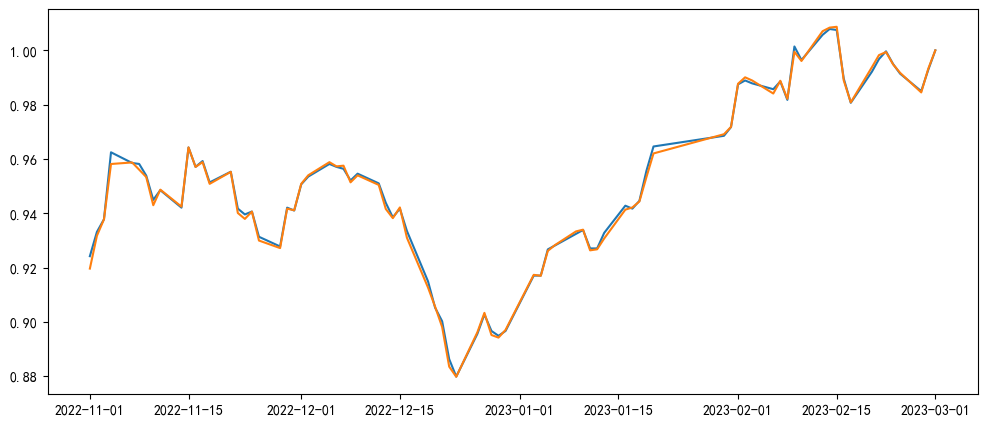

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(etf_price/etf_price.iloc[-1])
plt.plot(index_price/index_price.iloc[-1])